In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!git clone https://github.com/nicola-decao/s-vae-pytorch.git

Cloning into 's-vae-pytorch'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 107 (delta 0), reused 5 (delta 0), pack-reused 98
Receiving objects: 100% (107/107), 29.69 KiB | 14.84 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [3]:
!python s-vae-pytorch/setup.py install

running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating hyperspherical_vae.egg-info
writing hyperspherical_vae.egg-info/PKG-INFO
writing dependency_links to hyperspherical_vae.egg-info/dependency_links.txt
writing requirements to hyperspherical_vae.egg-info/requires.txt
writing top-level names to hyperspherical_vae.egg-info/top_level.txt
writing manifest file 'hyperspherical_vae.egg-info/SOURCES.txt'
reading manifest file 'hyperspherical_vae.egg-info/SOURCES.txt'
writing manifest file 'hyperspherical_vae.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x8

In [4]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=58ce97d52489c9d9b05b18ed902fd99e3620c5a3550d9c61299f4196b56f7274
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=ef7b9a37dd14666003

In [5]:
!pip3 install bbknn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.2-cp39-cp39-linux_x86_64.whl size=582232 sha256=28dbc0cec45ede7628df505f9af8d486a68418ea7d46857e317fba687b9a4d45
  Stored in directory: /root/.cache/pip/wheels/f2/2e/e4/f3ae385c375b87982a2a70055061d4a6330ef4f60817e717e3
Successfully built annoy


In [6]:
import sys as sys
print(sys.path)

sys.path.append("/content/s-vae-pytorch")

['/content', '/env/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.9/dist-packages/IPython/extensions', '/root/.ipython']


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os as os
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from collections import defaultdict

from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform

In [8]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


In [64]:
def read_data(filename):
  adata = sc.read_h5ad(filename)
  return adata

In [92]:
file_path = "./drive/MyDrive/immune_cell_dataset/"
# data can be myeloid, b_cells, or t_cells
data = "myeloid"
file_path = os.path.join(file_path, data)
if data == "myeloid":
  filename = "myeloid.h5ad"
elif data == "b_cells":
  filename = "b-cells.h5ad"
else:
  filename = "t-cells.h5ad"
file_path = os.path.join(file_path, filename)

adata = read_data(file_path)

In [93]:
# adata.X is the cell by gene matrix
# myeloid is 51,552 x 36,601
# t_cells is 216,611 x 36,601
# b_cells is 54,934 x 36,601
# dtype is float 32
adata.X.shape

(51552, 36601)

Data preprocessing

In [94]:
# Data already normalized and log-transformed
# Select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
print(adata.X.shape)
# Scale to unit variance and zero mean
sc.pp.scale(adata)

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
(51552, 1816)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Get rid of batch effects

In [95]:
import bbknn

bbknn.ridge_regression(adata, batch_key=['Chemistry'])

computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:01)


Small dataset below just for testing purposes

In [208]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [11]:
!mkdir data/filtered_gene_bc_matrices

In [12]:
!mkdir data/filtered_gene_bc_matrices/hg19

In [87]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [14]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [15]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [16]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [17]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [18]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
sc.pp.log1p(adata)

In [21]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [22]:
adata.raw = adata

In [23]:
adata = adata[:, adata.var.highly_variable]

In [24]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:09)


In [25]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


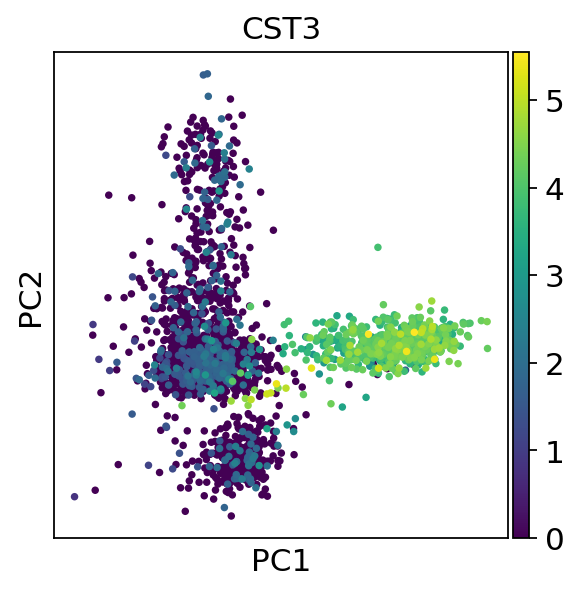

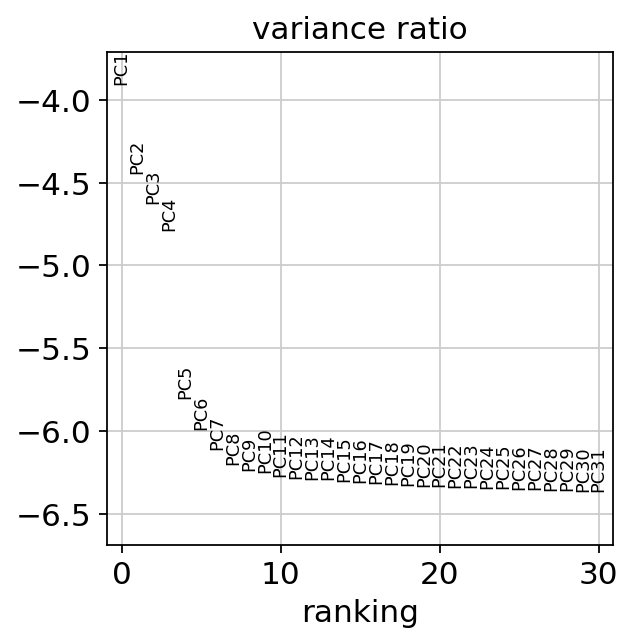

In [26]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
# Originally 2700 x 32738
# After preprocessing, 2638 x 1838
adata.X.shape

(2638, 1838)

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [30]:
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.3 MB/s eta 0:00:00


In [31]:
!pip install louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.2 MB/s eta 0:00:00


In [32]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [34]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


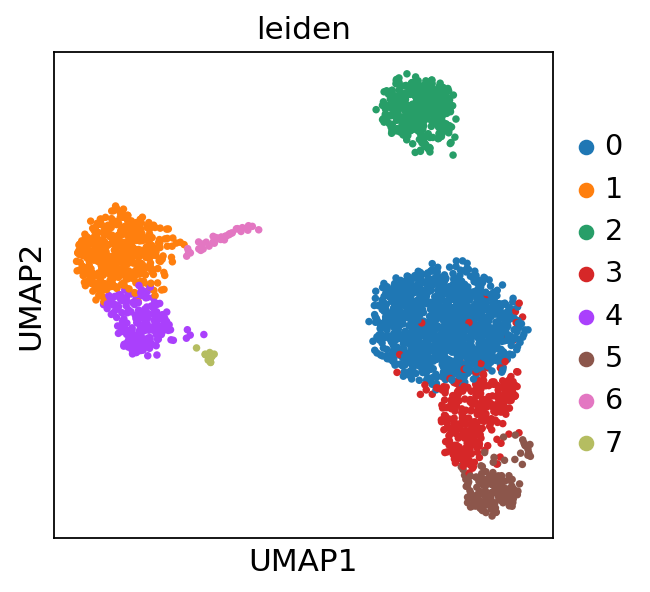

In [36]:
sc.pl.umap(adata, color=['leiden'])

Hyperspherical VAE

Model

In [37]:
class ModelVAE(torch.nn.Module):
    
    def __init__(self, n_gene, z_dim=2,
                 encoder_layer=None, decoder_layer=None, activation=F.relu,
                 distribution='normal', x=None):
        """
        ModelVAE initializer
        :param z_dim: dimension of the latent representation
        :encoder_layer: a list containing the units of each layer in the encoder
        :decoder_layer: a list containing the units of each layer in the decoder
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(ModelVAE, self).__init__()
        
        # Creat layers for encoder
        if encoder_layer is None:
          encoder_layer = [128, 64, 32]
        self.encoder_layer = [nn.Linear(n_gene, encoder_layer[0])]
        # BatchNorm
        self.encoder_batch_norm = [nn.BatchNorm1d(encoder_layer[0])]
        for i in range(1, len(encoder_layer)):
            self.encoder_layer.append(nn.Linear(encoder_layer[i-1], encoder_layer[i]))
            # BatchNorm
            self.encoder_batch_norm.append(nn.BatchNorm1d(encoder_layer[i]))
        self.encoder_layer = nn.ModuleList(self.encoder_layer)
        # BatchNorm
        self.encoder_batch_norm = nn.ModuleList(self.encoder_batch_norm)

        # Create layers for decoder
        if decoder_layer is None:
          decoder_layer = [32, 128]
        self.decoder_layer = [nn.Linear(z_dim, decoder_layer[0])]
        # BatchNorm
        self.decoder_batch_norm = [nn.BatchNorm1d(decoder_layer[0])]
        for i in range(1, len(decoder_layer)):
          self.decoder_layer.append(nn.Linear(decoder_layer[i-1], decoder_layer[i]))
          # BatchNorm
          self.decoder_batch_norm.append(nn.BatchNorm1d(decoder_layer[i]))
        self.decoder_layer = nn.ModuleList(self.decoder_layer)
        # BatchNorm
        self.decoder_batch_norm = nn.ModuleList(self.decoder_batch_norm)

        if distribution == "normal":
          # Output of encoder
          self.fc_mean = nn.Linear(encoder_layer[-1], z_dim)
          self.fc_var = nn.Linear(encoder_layer[-1], z_dim)
          # Output of decoder
          self.mu_layer = nn.Linear(decoder_layer[-1], n_gene)
          self.var_layer = nn.Linear(decoder_layer[-1], n_gene)
        elif distribution == "vmf":
          # Output of encoder
          self.fc_mean = nn.Linear(encoder_layer[-1], z_dim)
          self.fc_var = nn.Linear(encoder_layer[-1], 1)
          # Output of decoder
          self.mu_layer = nn.Linear(decoder_layer[-1], n_gene)
          self.var_layer = nn.Linear(decoder_layer[-1], n_gene)
        else:
          raise NotImplemented

        self.z_dim, self.activation, self.distribution = z_dim, activation, distribution
        self.n_input_feature = n_gene

    def encode(self, x):
        # regularizer = torch.
        
        h = self.encoder_layer[0](x)
        h = self.activation(h)
        # Add in batch normalization here
        # h = self.encoder_batch_norm[0](h)
        for i in range(1, len(self.encoder_layer)):
          h = self.encoder_layer[i](h)
          h = self.activation(h)
          # Add in batch normalization here
          # h = self.encoder_batch_norm[i](h)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(h)
            z_var = F.softplus(self.fc_var(h))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(h)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(h)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        # l2 regularization goes here

        h = self.decoder_layer[0](z)
        h = self.activation(h)
        # Add in batch normalization here
        # h = self.decoder_batch_norm[0](h)
        for i in range(1, len(self.decoder_layer)):
          h = self.decoder_layer[i](h)
          h = self.activation(h)
          # Add in batch normalization here
          # h = self.decoder_batch_norm[i](h)

        mu = self.mu_layer(h)
        sigma_square = F.softplus(self.var_layer(h))
        sigma_sqare = torch.clip(sigma_square, 1e-6, 1e10)
        return mu, sigma_square
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.z_dim - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        mu_, sigma_square_ = self.decode(z)
        return (z_mean, z_var), (q_z, p_z), z, mu_, sigma_square_

Log likelihood

In [38]:
# def log_likelihood(model, x, n=10):
    # """
    # :param model: model object
    # :param optimizer: optimizer object
    # :param n: number of MC samples
    # :return: MC estimate of log-likelihood
    # """
    # z_mean, z_var = model.encode(x)
    # q_z, p_z = model.reparameterize(z_mean, z_var)
    # z = q_z.rsample(torch.Size([n]))
    # mu_, sigma_square_ = model.decode(z)

    # log_p_z = p_z.log_prob(z)

    # if model.distribution == 'normal':
        # log_p_z = log_p_z.sum(-1)

    # log_p_x_z = -nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x.reshape(-1, 784).repeat((n, 1, 1))).sum(-1)
    # log_p_x_z = log_likelihood_nb(x, mu_, sigma_square_).sum(-1)

    # log_q_z_x = q_z.log_prob(z)

    # if model.distribution == 'normal':
        # log_q_z_x = log_q_z_x.sum(-1)

    # return ((log_p_x_z + log_p_z - log_q_z_x).t().logsumexp(-1) - np.log(n)).mean()

In [39]:
def log_likelihood(model, x, n=10):
  z_mean, z_var = model.encode(x)
  q_z, p_z = model.reparameterize(z_mean, z_var)
  z = q_z.rsample(torch.Size([n]))
  mu_, sigma_square_ = model.decode(z)

  # In scPhere used tf.reduce_mean()
  return torch.mean(log_likelihood_student(x, mu_, sigma_square_, df=2.0))

In [40]:
def log_likelihood_nb(x, mu, sigma, eps=1e-16):

    log_mu_sigma = torch.log(mu + sigma + eps)

    ll = torch.lgamma(x + sigma) - torch.lgamma(sigma) - \
        torch.lgamma(x + 1) + sigma * torch.log(sigma + eps) - \
        sigma * log_mu_sigma + x * torch.log(mu + eps) - x * log_mu_sigma

    return torch.mean(ll, dim=-1)

In [41]:
def log_likelihood_student(x, mu, sigma_square, df=2.0):
    sigma = torch.sqrt(sigma_square)
    
    dist = torch.distributions.studentT.StudentT(df=df,
                                             loc=mu,
                                             scale=sigma)
    
    # return tf.reduce_sum(dist.log_prob(x), reduction_indices=1)
    return torch.mean(dist.log_prob(x), dim=1)

Training and testing

In [101]:
def train(model, optimizer):
    # for i, (x_mb, y_mb) in enumerate(train_loader):
    for i in range(0, X.shape[0], 128):
    # for x in X:
            if i+128 < X.shape[0]:
              x = X[i: i+128, :]
            else:
              x = X[i:, :]
            optimizer.zero_grad()
            
            # dynamic binarization
            # x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape)).float()
            
            # _, (q_z, p_z), _, x_mb_ = model(x_mb.reshape(-1, 784))
            (z_mean, z_var), (q_z, p_z), _, mu, sigma_square = model(x)
            
            # loss_recon = nn.BCEWithLogitsLoss(reduction='none')(x_reconstructed, x).sum(-1).mean()
            # loss_recon = log_likelihood(x, z_mean, z_var)
            # library_size = torch.sum(x, dim=1, keepdim=True)
            # mu = mu * library_size
            # loss_recon = log_likelihood_nb(
                # x,
                # mu,
                # sigma_square,
            # ).sum(-1).mean()
            # loss_recon = torch.mean(log_likelihood_nb(x, mu, sigma_square, eps=1e-10))
            loss_recon = torch.mean(log_likelihood_student(x, mu, sigma_square, df=5.0))

            if model.distribution == 'normal':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
            elif model.distribution == 'vmf':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
            else:
                raise NotImplemented
            loss = loss_recon - loss_KL
            # loss = loss_recon + loss_KL

            loss.backward()
            optimizer.step()

In [102]:
def test(model, optimizer):
    print_ = defaultdict(list)
    # for x_mb, y_mb in test_loader:
    for i in range(0, X.shape[0], 128):   
        if i+128 < X.shape[0]:
          x = X[i :i+128, :]
        else:
          x = X[i:, :]
        
        # dynamic binarization
        # x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape)).float()
        
        # _, (q_z, p_z), _, x_mb_ = model(x_mb.reshape(-1, 784))
        _, (q_z, p_z), _, mu_, sigma_square_ = model(x)
        
        # print_['recon loss'].append(float(nn.BCEWithLogitsLoss(reduction='none')(x_mb_,
            # x_mb.reshape(-1, 784)).sum(-1).mean().data))
        # library_size = torch.sum(x, dim=1, keepdim=True)
        # mu_ = mu_* library_size
        # print_['recon loss'].append(float(torch.mean(log_likelihood_nb(x, mu_, sigma_square_)).data))
        print_['recon loss'].append(float(torch.mean(log_likelihood_student(x, mu_, sigma_square_, df=5.0)).data))

        if model.distribution == 'normal':
            print_['KL'].append(float(torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean().data))
        elif model.distribution == 'vmf':
            print_['KL'].append(float(torch.distributions.kl.kl_divergence(q_z, p_z).mean().data))
        else:
            raise NotImplemented
        
        print_['ELBO'].append(- print_['recon loss'][-1] - print_['KL'][-1])
        print_['LL'].append(float(log_likelihood(model, x).data))
    
    print({k: np.mean(v) for k, v in print_.items()})

In [104]:
# hidden dimension and dimension of latent space
H_DIM = 128
Z_DIM = 2
torch.autograd.set_detect_anomaly(True)
X = torch.tensor(adata.X)
X = X.float()
n_gene = X.numpy().shape[1]

# normal VAE
#modelN = ModelVAE(n_gene=n_gene, z_dim=Z_DIM, encoder_layer=None, decoder_layer=None, distribution='normal', x=X)
# print(modelN.parameters)
optimizerN = optim.Adam(modelN.parameters(), lr=1e-3)

print('##### Normal VAE #####')

n_epochs = 1
# training for 1 epoch
# for i in range(0, n_epochs):
  # train(modelN, optimizerN)

# test
# test(modelN, optimizerN)

print()

# hyper-spherical  VAE
modelS = ModelVAE(n_gene=n_gene, z_dim=Z_DIM + 1, encoder_layer=None, decoder_layer=None, distribution='vmf')
# print(modelS.parameters)
optimizerS = optim.Adam(modelS.parameters(), lr=1e-4)

print('##### Hyper-spherical VAE #####')

s_epochs = 2
# training for 1 epoch
for i in range(0, s_epochs):
  train(modelS, optimizerS)

# test
test(modelS, optimizerS)

##### Normal VAE #####

##### Hyper-spherical VAE #####
{'recon loss': -99.44474404384717, 'KL': 5.6048629727612065, 'ELBO': 93.83988107108597, 'LL': -43.34362714403024}


In [196]:
torch.save({
    "Z_DIM": Z_DIM,
    "encoder_layer": None,
    "decoder_layer": None,
    "s_epochs": s_epochs,
    "model_state_dict": modelS.state_dict(),
    "optimizer_state_dict": optimizerS.state_dict()
},
"s_vae_" + data + "_" + str(Z_DIM))

In [197]:
# hyper-spherical  VAE
model = ModelVAE(n_gene=n_gene, z_dim=Z_DIM + 1, encoder_layer=None, decoder_layer=None, distribution='vmf')
# print(modelS.parameters)
optimizer = optim.Adam(modelS.parameters(), lr=1e-4)

checkpoint = torch.load("s_vae_myeloid_2")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

test(model, optimizer)

/usr/local/lib/python3.9/dist-packages/torch/distributions/distribution.py:51: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


{'recon loss': -99.44353210600671, 'KL': 5.6048629727612065, 'ELBO': 93.8386691332455, 'LL': -43.343652512240354}


Evaluation

In [207]:
adata

AnnData object with n_obs × n_vars = 51552 × 1816
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype', 'leiden', 'louvain', 'kmeans11'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'kmeans11_colors'
    obsm: 'X_umap', 'X_umap_original', 'vae_embeddings'
    layers: 'X_explained'
    obsp: 'distances', 'connectivities'

In [106]:
# Store original UMAP because going to overwrite using reduced examples from VAE
if "X_umap_original" not in adata.obsm:
  adata.obsm["X_umap_original"] = adata.obsm["X_umap"]

dist = "vmf"
if dist == "normal":
  (z_mean, _), (_, _), _, _, _ = modelN(X)
  dimensionality_reduced_data = z_mean.detach().numpy()
elif dist == "vmf":
  (z_mean, _), (_,_), _, _, _ = modelS(X)
  dimensionality_reduced_data = z_mean.detach().numpy()
else:
  raise NotImplementedError

# Store the embeddings in adata
adata.obsm["vae_embeddings"] = dimensionality_reduced_data

Visualization

In [107]:
if dist == "normal":
  if adata.obsm["vae_embeddings"].shape[1] == 2:
    sc.pl.embedding(adata, basis="vae_embeddings", color="leiden")
elif dist == "vmf":
  raise NotImplementedError
else:
  raise NotImplementedError

TypeError: ignored

Clustering

In [135]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

(51552, 3)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 70 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


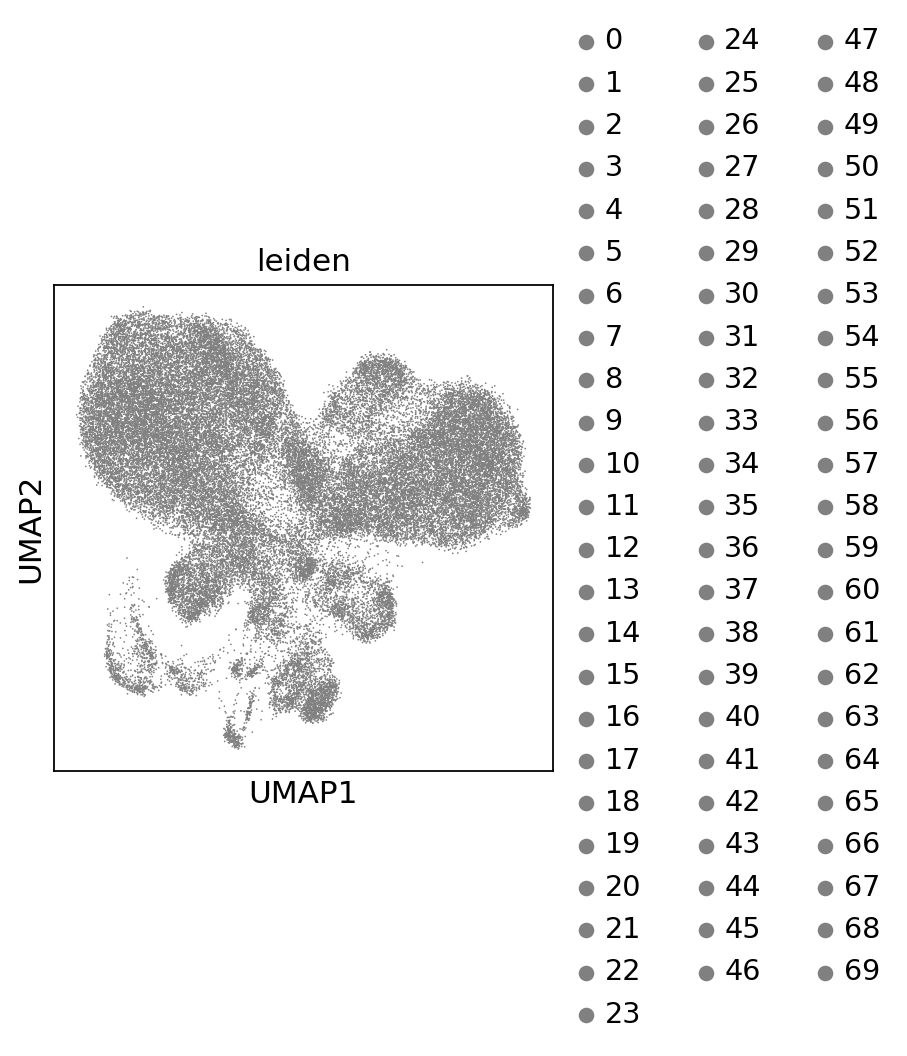

In [188]:
# Leiden clustering
clustering_type = "leiden"
if data == "myeloid":
  community_clustering(adata, clustering_type, 10, 0.6,
                    n_pcs=None, use_original_umap=True, save_figure=True)
elif data == "t-cells":
  community_clustering(adata, clustering_type, 10, 0.6,
                    n_pcs=None, use_original_umap=True, save_figure=False)
elif data == "b-cells":
  community_clustering(adata, clustering_type, 10, 0.6,
                    n_pcs=None, use_original_umap=True, save_figure=False)
else:
  raise NotImplementedError

(51552, 3)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 55 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


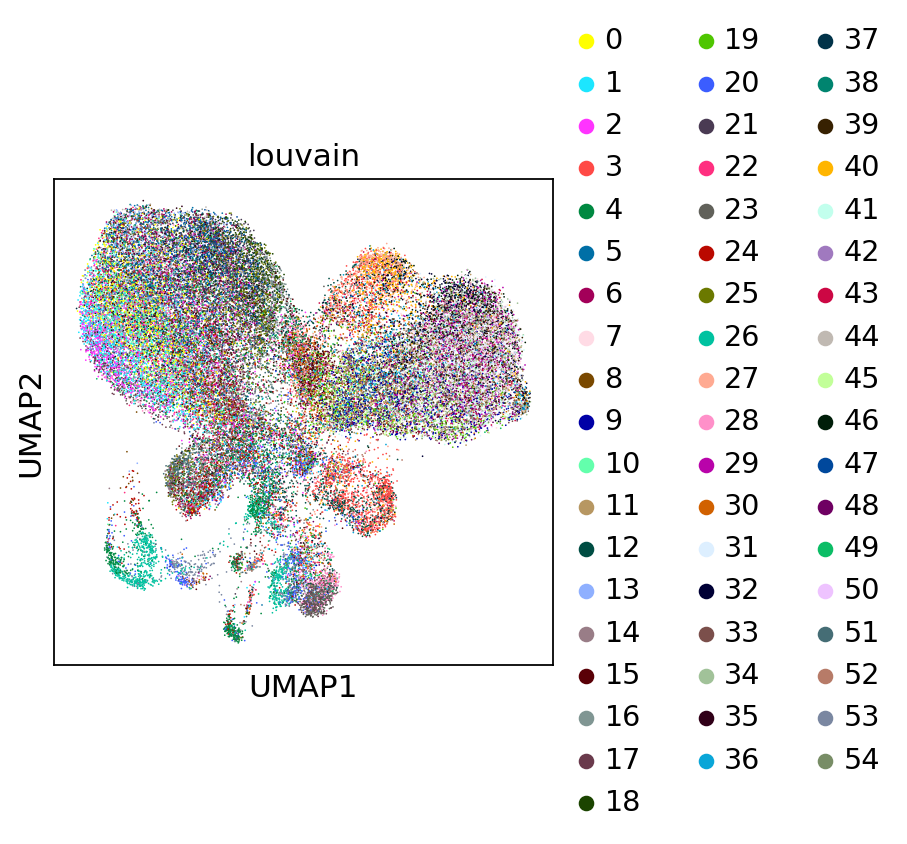

In [189]:
# Louvain clustering
clustering_type = "louvain"
if data == "myeloid":
  community_clustering(adata, clustering_type, 10, 0.6,
                    n_pcs=None, use_original_umap=True, save_figure=True)
elif data == "t-cells":
  community_clustering(adata, clustering_type, 10, 0.6,
                    n_pcs=None, use_original_umap=True, save_figure=False)
elif data == "b-cells":
  community_clustering(adata, clustering_type, 10, 0.6,
                    n_pcs=None, use_original_umap=True, save_figure=False)
else:
  raise NotImplementedError

In [175]:
# K-means
from sklearn.cluster import KMeans

max_clusters = 30
num_PCs = 3
distortions = np.zeros(max_clusters)
labels = []
for i in range(1, max_clusters+1):
  X_vae_embeddings = adata.obsm["vae_embeddings"][:, 0:num_PCs]
  kmeans = KMeans(n_clusters=i, random_state=0, n_init=20, max_iter=500, tol=1e-04).fit(X_vae_embeddings)
  
  distortions[i-1] = kmeans.inertia_
  labels.append(kmeans.labels_.astype(str))

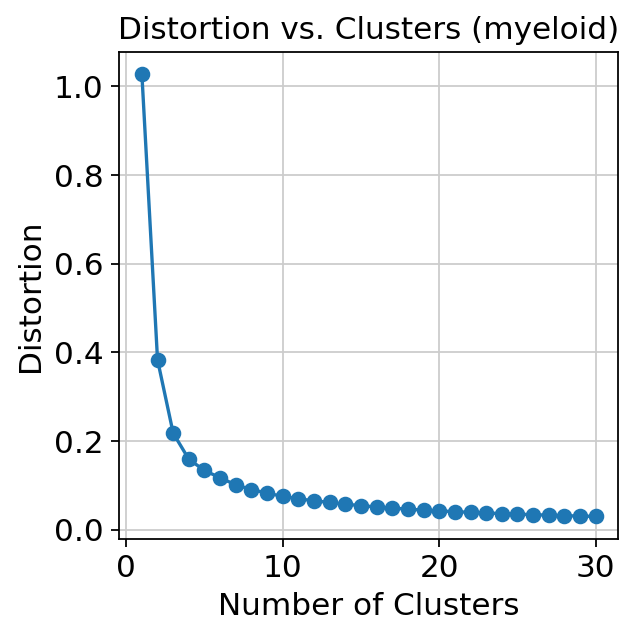

In [166]:
plt.plot(range(1, max_clusters+1), distortions, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.title("Distortion vs. Clusters (" + data + ")")
# distribution, dimension used to run kmeans, the dataset used
plt.savefig("./figures/kmeans_elbow_plot_" + data + "_" + dist + "_" + str(num_PCs) + ".png")
# plt.show()
# plt.close()

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


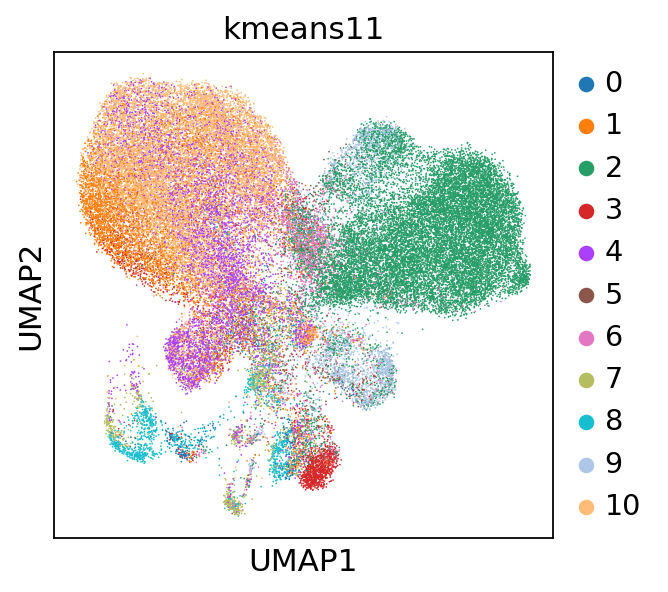

In [167]:
# If want k=1, put 1 and so on
desired_k = [11]

for k in desired_k:
  adata.obs['kmeans'+str(k)] = labels[k-1]

# The key is the number of clusters to visualize
# The value is whether the image should be saved or not
visualize_k = {11: True}

for k in visualize_k:
  save = None
  if visualize_k[k]:
    # dstribution, dataset, clustering method and number of clusters, dimension used to run kmeans
    save = "_" + "_".join([data, dist, "kmeans"+str(k), str(num_PCs)]) + ".png"
  sc.pl.umap(adata, color=['kmeans'+str(k)], save=save)

In [160]:
print(dist, data)

true_labels = ["Manually_curated_celltype"]
# If using kmeans, need to specify number of clusters at end
# For example, if want to calculate the score for kmeans with 8 clusters, should
# put kmeans8
clustering = "kmeans11"
for label in true_labels:
  print("ARI", label, clustering, adjusted_rand_score(adata.obs[label], adata.obs[clustering]))
  print("AMI", label, clustering, adjusted_mutual_info_score(adata.obs[label], adata.obs[clustering]))
  print("NMI", label, clustering, normalized_mutual_info_score(adata.obs[label], adata.obs[clustering]))

vmf myeloid
ARI Manually_curated_celltype kmeans11 0.5224768317756361
AMI Manually_curated_celltype kmeans11 0.4635439054997399
NMI Manually_curated_celltype kmeans11 0.46384817267956246


K-Nearest neighbors

In [267]:
proportion(adata.obs["Manually_curated_celltype"])

Proportion of Erythrophagocytic macrophages: 0.0407937616387337
Proportion of DC2: 0.02224937926753569
Proportion of DC1: 0.006905648665425201
Proportion of Intermediate macrophages: 0.04337368094351335
Proportion of Alveolar macrophages: 0.3343808193668529
Proportion of Classical monocytes: 0.4237856921166977
Proportion of Nonclassical monocytes: 0.046942892613283674
Proportion of Cycling: 0.02252094972067039
Proportion of migDC: 0.005082247051520794
Proportion of MNP/T doublets: 0.042345592799503416
Proportion of Intestinal macrophages: 0.01161933581626319


In [260]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

X = adata.obsm["vae_embeddings"]
y = np.array(adata.obs["Manually_curated_celltype"])
skf = StratifiedKFold(n_splits=10)

neighbors = [5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65]
accuracies = {}
for k in neighbors:
  for train, test in skf.split(X, y):
    classifier = KNeighborsClassifier(k)
    classifier.fit(X[train], y[train])
    predictions = classifier.predict(X[test])

    accuracy = sum(predictions == y[test]) / len(y[test])
    if k not in accuracies:
      accuracies[k] = [accuracy]
    else:
      accuracies[k].append(accuracy)

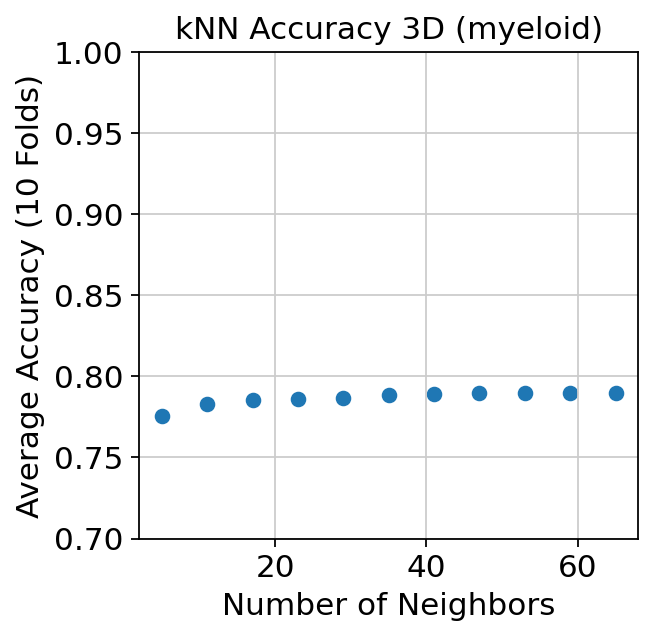

In [266]:
x = [k for k in accuracies]
y = [sum(accuracies[k])/len(accuracies[k]) for k in accuracies]

plt.scatter(x, y)
plt.ylim(0.7, 1.0)
plt.title(f"kNN Accuracy {X.shape[1]}D ({data})")
plt.xlabel("Number of Neighbors")
plt.ylabel("Average Accuracy (10 Folds)")
plt.show()
plt.close()

Functions need to run evalution

In [187]:
# Leiden or Louvain clustering
def community_clustering(adata, clustering_type, l_neighbors, l_resolution,
                         n_pcs=None, use_original_umap=True, save_figure=False):
  """
  Clustering.
  l_neighbors: The number of neighbors to use when creating the neighborhood map.
  l_resolution: Controls coarseness of clustering. Higher values means more clusters.
  n_pcs: Dimension to use when computing neighborhood map.

  If save_figure=True, saves to a directory called figures with the following
  information in the image name
  data name (myeloid, t-cells or b-cells),
  distribution
  dimension of embeddings
  clustering method,
  dimension used to compute neighbors map,
  number of neighbors
  resolution starting with an r, for example r0_6 is r0.6
  original if use_original_umap is True and computed otherwise
  """
  if n_pcs is None:
    n_pcs = adata.obsm["vae_embeddings"].shape[1]
  sc.pp.neighbors(adata, n_neighbors=l_neighbors, n_pcs=n_pcs, use_rep="vae_embeddings")
  if clustering_type == "leiden":
    sc.tl.leiden(adata, resolution=l_resolution)
  else:
    sc.tl.louvain(adata, resolution=l_resolution)

  # Warning, the umap in X.obsm["umap"] is overwritten with the original umap when
  # set to True
  # Otherwise, X.obsm["umap"] is overwritten with the new umap
  if use_original_umap:
    adata.obsm["X_umap"] = adata.obsm["X_umap_original"]
  else:
    sc.tl.umap(adata)

  save=None
  if save_figure:
    information = [data,
                   dist,
                   clustering_type,
                   str(n_pcs),
                   str(l_neighbors),
                   "r" + "_".join(str(l_resolution).split(".")),
                   "original" if use_original_umap else "computed"
                   ]
    save = "_" + "_".join(information) + ".png"
  sc.pl.umap(adata, color=clustering_type, save=save)

In [226]:
def proportion(desired_labels):
  for label in desired_labels.unique():
    print(f"Proportion of {label}: {sum(desired_labels == label)/true_labels.size}")

Outputting proportions of different labels

In [232]:
proportion(adata.obs["Manually_curated_celltype"])

Proportion of Erythrophagocytic macrophages: 0.0407937616387337
Proportion of DC2: 0.02224937926753569
Proportion of DC1: 0.006905648665425201
Proportion of Intermediate macrophages: 0.04337368094351335
Proportion of Alveolar macrophages: 0.3343808193668529
Proportion of Classical monocytes: 0.4237856921166977
Proportion of Nonclassical monocytes: 0.046942892613283674
Proportion of Cycling: 0.02252094972067039
Proportion of migDC: 0.005082247051520794
Proportion of MNP/T doublets: 0.042345592799503416
Proportion of Intestinal macrophages: 0.01161933581626319


In [227]:
proportion(adata.obs["Donor"])

Proportion of A29: 0.06870732464307883
Proportion of A31: 0.03452824332712601
Proportion of A36: 0.08562228429546866
Proportion of A35: 0.03445065176908752
Proportion of A37: 0.008069522036002483
Proportion of A52: 0.023005896958410925
Proportion of 582C: 0.007856145251396648
Proportion of 621B: 0.004636095592799504
Proportion of 637C: 0.02110490378646803
Proportion of 640C: 0.035750310366232156
Proportion of D503: 0.19444444444444445
Proportion of D496: 0.4818241775294848


In [ ]:
for donor in adata.obs["Donor"].unique():
  proportion(adata.obs["Manually_curated_celltype"][adata.obs["Donor"] == donor])
  print()